## Translation in Julia of Ole Sigmund top99 code

Robin Grapin

In [2]:
#imports
using SparseArrays
using Plots

# 2 dofs only : x and y
# material properties
E = 1.; 
nu = 0.3;
k=[ 1/2-nu/6   1/8+nu/8 -1/4-nu/12 -1/8+3*nu/8 -1/4+nu/12 -1/8-nu/8  nu/6  1/8-3*nu/8];
#elementary matrix of stiffness
KE = E/(1-nu^2)*[ k[1] k[2] k[3] k[4] k[5] k[6] k[7] k[8];
                  k[2] k[1] k[8] k[7] k[6] k[5] k[4] k[3];
                  k[3] k[8] k[1] k[6] k[7] k[4] k[5] k[2];
                  k[4] k[7] k[6] k[1] k[8] k[3] k[2] k[5];
                  k[5] k[6] k[7] k[8] k[1] k[2] k[3] k[4];
                  k[6] k[5] k[4] k[3] k[2] k[1] k[8] k[7];
                  k[7] k[4] k[5] k[2] k[3] k[8] k[1] k[6];
                  k[8] k[3] k[2] k[5] k[4] k[7] k[6] k[1]];


In [3]:
function top(nelx,nely,volfrac,penal,rmin)
    
    # applied stress F[2,1] = -1 -> on the secod dof (y) of the first pixel (top left corner), we add an elementary effort (-1) in the direction of the top
    ddl = 2*(nely+1)*(nelx+1) #dofs
    F= zeros(ddl);
    F[2] = -1; 
    
    #fixed and free nodes ( here teh problem is the half beam MBB)    
    fixeddofs   = union(1:2:2*(nely+1),[ddl]); #some dofs (x) are artificially fixed to materialize the symmetry
    alldofs     = 1:ddl;
    freedofs    = setdiff(alldofs,fixeddofs);
    
    x = volfrac * ones(nely,nelx) ; #uniform repartition of the mass at the beginning
    loop = 0; 
    change = 1.; #arbitrary, to start the loop
    dc = zeros(nely,nelx);
    cValues = []
    while change > 0.01  
        loop += 1;
        xold = x; # xold is the old mass repartition      
        c = 0.; # objective function here :  the energy of deformation
        U = FE(nelx,nely,x,penal, freedofs, fixeddofs,F);
        for ely = 1:nely
            for elx = 1:nelx
                n1 = (nely+1)*(elx-1)+ely; 
                n2 = (nely+1)* elx   +ely;
                Ue = append!([U[2*n1-1]],append!([U[2*n1]],append!([U[2*n2-1]],append!([U[2*n2]],append!([U[2*n2+1]],append!([U[2*n2+2]],append!([U[2*n1+1]],[U[2*n1+2]]))))))); #the 4 nodes of the element
                c = c + x[ely,elx]^penal*Ue'*KE*Ue; # elementary participation to Edeformation
                dc[ely,elx] = -penal*x[ely,elx]^(penal-1)*Ue'*KE*Ue; # dc/dx (Xe)
            end
        end
        push!(cValues,c)
        dc = check(nelx,nely,rmin,x,dc);
        x  = OC(nelx,nely,x,volfrac,dc);
        change = maximum(abs.(x-xold));
        println("change = ", change, "c = ", c);
        if loop==25
            return x,cValues,loop
        end
    end
    return x,cVlaues,loop
end

top (generic function with 1 method)

In [4]:
function OC(nelx,nely,x,volfrac,dc)  # new mass repartition
    l1 = 0; l2 = 100000; move = 0.2;
    xnew = zeros(nely,nelx);    
    while (l2-l1 > 1e-4) #research of the lagrangian multilicator through dichotomy
        lmid = 0.5*(l2+l1);
        RacBe = sqrt.(-dc/lmid) ; # sqrt(Be) = -dc/(l * dv) and Xe* Be^1/2 .  xnew € [x-move, x+move]
        XB = x.*RacBe ;
        for i = 1:nelx
            for j = 1:nely
                xji = x[j,i];
                xnew[j,i]= max(0.001,max(xji-move,min(1,min(xji+move,XB[j,i]))));
            end
        end        
        if sum(sum(xnew)) - volfrac*nelx*nely > 0;
            l1 = lmid;
        else
            l2 = lmid;
        end
    end
    return xnew
end

OC (generic function with 1 method)

In [5]:
function FE(nelx,nely,x,penal, freedofs, fixeddofs, F) #Creation of the global stifness matrix, resolution of the displacements
    K = spzeros(2*(nelx+1)*(nely+1), 2*(nelx+1)*(nely+1)); # sparse matrix of the global stifness  
    U = zeros(2*(nely+1)*(nelx+1));
    for elx = 1:nelx
      for ely = 1:nely # loop for every element
        n1 = (nely+1)*(elx-1)+ely; #node on the left top of the element 
        n2 = (nely+1)* elx   +ely; #right top
        edof = [2*n1-1; 2*n1; 2*n2-1; 2*n2; 2*n2+1; 2*n2+2; 2*n1+1; 2*n1+2]; # the 2 dofs of each of the 4 nodes of the element
        K[edof,edof] += x[ely,elx]^penal*KE; # c(x) = sum on e( Xe^p * Ue' * KE * Ue) => K = (Xe^p*KE)e
      end
    end
    U[freedofs] = K[freedofs,freedofs] \ F[freedofs]; 
    U[fixeddofs] .= 0;
    return U
end

FE (generic function with 1 method)

In [6]:
function check(nelx,nely,rmin,x,dc) # filtering to be sure of he existence of solutions
    dcn=zeros(nely,nelx); #filtered dc/dx . Hf = Rmin - dist(e,f)
    for i = 1:nelx
      for j = 1:nely
        sum=0.0;
        for k = max(i-floor(rmin),1):min(i+floor(rmin),nelx)
          for l = max(j-floor(rmin),1):min(j+floor(rmin),nely)
            fac = rmin-sqrt((i-k)^2+(j-l)^2);
            sum = sum+max(0,fac); 
            dcn[j,i] += max(0,fac)*x[l,k]*dc[l,k];
          end
        end
        dcn[j,i] = dcn[j,i]/(x[j,i]*sum);
      end
    end
    return dcn
end

check (generic function with 1 method)

change = 0.2c = 240.55295797268946
change = 0.20000000000000007c = 142.17900808909855
change = 0.20000000000000007c = 101.96705996828744
change = 0.20000000000000007c = 82.42009077779126
change = 0.20000000000000007c = 73.87933102804553
change = 0.2c = 67.57751539753602
change = 0.1692438717135697c = 63.42635663032229
change = 0.1424340357866224c = 61.05609760474731
change = 0.1631616850400155c = 59.394304215155074
change = 0.13707745286782547c = 57.96507558910982
change = 0.1740902643107608c = 56.48944702364758
change = 0.17714069897131868c = 54.71453615940355
change = 0.20000000000000007c = 52.795844691904534
change = 0.20000000000000007c = 51.239015326952234
change = 0.17179597655086665c = 50.239263702718546
change = 0.13231951929612018c = 49.62505117567204
change = 0.13291514575716343c = 49.212430268245164
change = 0.11549171936232808c = 48.86540750738922
change = 0.07971416509444079c = 48.598735760243834
change = 0.06776078298011257c = 48.525640846747436
change = 0.063003034611685

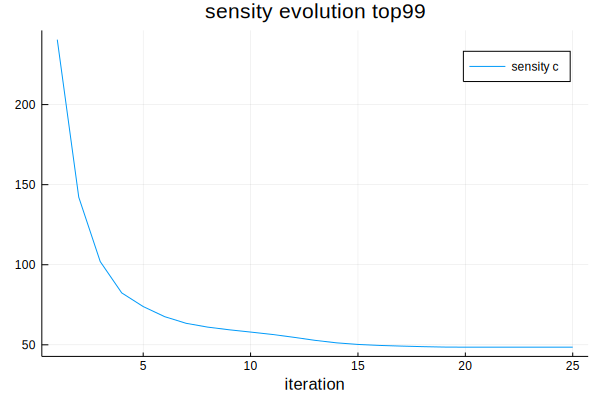

In [7]:
x,c,l = top(50,33,0.5,3,2);
plot(1:l,c,title = "sensity evolution top99", label = "sensity c") #evolution of c during the process
xlabel!("iteration")

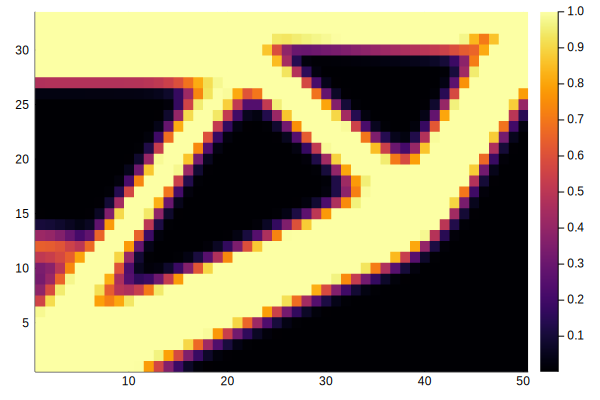

In [8]:
c2 = [ 240.55295821333357,
 142.29012812657385,
 101.29042745369344,
  80.66559467707458,
  70.50380077726645,
  62.76373407502861,
  57.569456923643784,
  53.32531768875428,
  50.258491516100314,
  48.810735392503446,
  48.11940887678135,
  47.70674371910807,
  47.47118107678733,
  47.343485675725475,
  47.23921449548786,
  47.127973767283066,
  46.99585044365262,
  46.79670069347179,
  46.53871598798251,
  46.30448641143472,
  46.23496928553922,
  46.18414430101558,
  46.1377939278308,
  46.095353434995985,
  46.05217114719343]#values for 25 iterations of top88 : top88(50,33,0.5, 3,2,1);
heatmap(x)

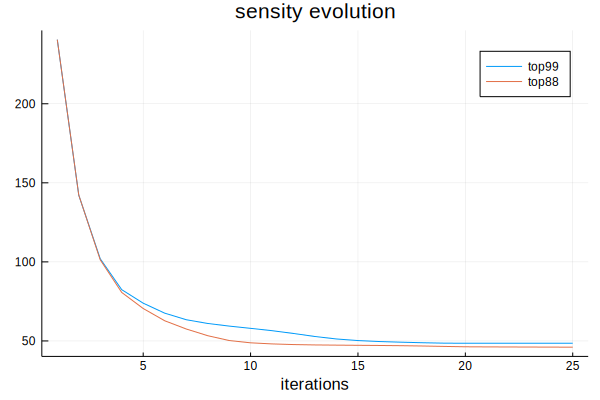

In [9]:
plot(1:l, [c,c2],title = "sensity evolution", label = ["top99" "top88"]) #comparation
xlabel!("iterations")